# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                       #transforms.RandomCrop((28,28), padding=2),
                                       transforms.RandomRotation((-10,10), fill=(1,)),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 111904952.38it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 95008387.31it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32415556.51it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22074772.62it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model
Let's start with the model we first saw

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:

# importing the model from the model.py
from model import Net

model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              36
       BatchNorm2d-2            [-1, 4, 26, 26]               8
              ReLU-3            [-1, 4, 26, 26]               0
            Conv2d-4            [-1, 4, 24, 24]             144
       BatchNorm2d-5            [-1, 4, 24, 24]               8
              ReLU-6            [-1, 4, 24, 24]               0
            Conv2d-7            [-1, 4, 22, 22]             144
       BatchNorm2d-8            [-1, 4, 22, 22]               8
              ReLU-9            [-1, 4, 22, 22]               0
          Dropout-10            [-1, 4, 22, 22]               0
        MaxPool2d-11            [-1, 4, 11, 11]               0
           Conv2d-12            [-1, 8, 11, 11]              32
      BatchNorm2d-13            [-1, 8, 11, 11]              16
             ReLU-14            [-1, 8,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
# Function fopr Training the model of the train dataset.
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        output = model(data)

        # Calculate loss
        loss = F.nll_loss(output, target)
        train_loss+=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(output, target)
        processed += len(data)
        #pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')


    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))

# Testing the trained model on test dataset to the check loss and model accuracy
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Let's Train and test our model

In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)

    test(model, device, test_loader)

    scheduler.step()

EPOCH: 0


Train: Loss=0.1848 Batch_id=468 Accuracy=88.05: 100%|██████████| 469/469 [00:22<00:00, 21.19it/s]



Test set: Average loss: 0.0958, Accuracy: 9716/10000 (97.16%)

EPOCH: 1


Train: Loss=0.0201 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:22<00:00, 21.29it/s]



Test set: Average loss: 0.0514, Accuracy: 9844/10000 (98.44%)

EPOCH: 2


Train: Loss=0.0735 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:21<00:00, 21.51it/s]



Test set: Average loss: 0.0383, Accuracy: 9885/10000 (98.85%)

EPOCH: 3


Train: Loss=0.0236 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:22<00:00, 20.74it/s]



Test set: Average loss: 0.0388, Accuracy: 9878/10000 (98.78%)

EPOCH: 4


Train: Loss=0.1085 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:22<00:00, 20.74it/s]



Test set: Average loss: 0.0321, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Train: Loss=0.0670 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:22<00:00, 20.46it/s]



Test set: Average loss: 0.0303, Accuracy: 9904/10000 (99.04%)

EPOCH: 6


Train: Loss=0.0638 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:23<00:00, 20.25it/s]



Test set: Average loss: 0.0238, Accuracy: 9932/10000 (99.32%)

EPOCH: 7


Train: Loss=0.0321 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:24<00:00, 19.37it/s]



Test set: Average loss: 0.0238, Accuracy: 9934/10000 (99.34%)

EPOCH: 8


Train: Loss=0.0580 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:23<00:00, 20.37it/s]



Test set: Average loss: 0.0230, Accuracy: 9935/10000 (99.35%)

EPOCH: 9


Train: Loss=0.0692 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:22<00:00, 20.43it/s]



Test set: Average loss: 0.0226, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Train: Loss=0.0229 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:22<00:00, 20.51it/s]



Test set: Average loss: 0.0217, Accuracy: 9945/10000 (99.45%)

EPOCH: 11


Train: Loss=0.0168 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:22<00:00, 20.40it/s]



Test set: Average loss: 0.0214, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Train: Loss=0.0569 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:22<00:00, 20.83it/s]



Test set: Average loss: 0.0214, Accuracy: 9940/10000 (99.40%)

EPOCH: 13


Train: Loss=0.0650 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:21<00:00, 21.52it/s]



Test set: Average loss: 0.0214, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Train: Loss=0.0754 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]



Test set: Average loss: 0.0212, Accuracy: 9939/10000 (99.39%)



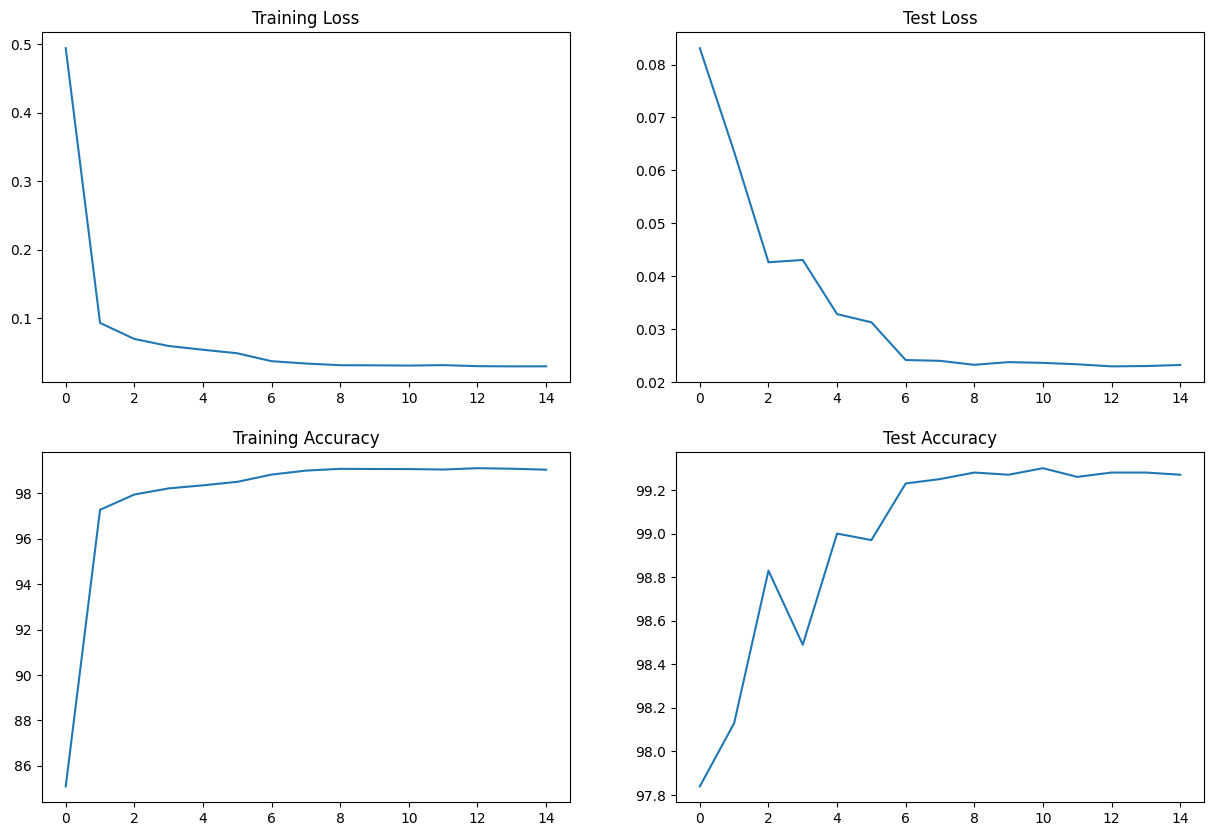

In [ ]:
# Display the loss and accuracy in tranining and Test Data.
from utils import display_plot

display_plot(train_losses,train_acc,test_losses,test_acc)

## Model 3

Results:

*   Parameters: 7,596
*   Best Train Accuracy: 99.09%
*   Best Test Accuracy: 99.45%


*   Analysis:
1. Model is underfitting.
2. The accuracy has reached the 99.45% with the change in the Learning rate.
